### Housing Violations Dataset Exploration


Now that we have all of our data, we want to start finding trends and visualizing the data. We come into this asking some very elementary questions. At this point we just want to catergorize our data. We are going to want to see which boros have the most incidents and how long they take to respond to see if there are any problems in some boros but to do so we need to see the shape of our data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [3]:
df = pd.read_csv('../data/clean.csv', parse_dates = ['inspectiondate',
                                                     'currentstatusdate']).drop('newcorrectbydate',axis=1)

In [4]:
df.count()

violationid              49377
buildingid               49377
boro                     49377
zip                      49375
inspectiondate           49377
originalcorrectbydate    48724
novdescription           49377
class                    49377
currentstatus            49377
currentstatusdate        49377
currentstatusdate        49377
dtype: int64

So we see we have a lot of rows to work with. Now on a most basic level we want to see what the status of these violations are

In [5]:
statusCounts = df.currentstatus.value_counts()
statusCounts

VIOLATION CLOSED                            41426
VIOLATION DISMISSED                          4113
FIRST NO ACCESS TO RE- INSPECT VIOLATION     1428
NOT COMPLIED WITH                            1274
NOV SENT OUT                                  559
DEFECT LETTER ISSUED                          175
NOV CERTIFIED LATE                            171
SECOND NO ACCESS TO RE-INSPECT VIOLATION      139
VIOLATION WILL BE REINSPECTED                  23
INVALID CERTIFICATION                          22
INFO NOV SENT OUT                              21
FALSE CERTIFICATION                            19
NOTICE OF ISSUANCE SENT TO TENANT               3
CIV14 MAILED                                    3
VIOLATION REOPEN                                1
Name: currentstatus, dtype: int64

Interestingly enough, most of the cases are closed. Now what can cause a violation to be closed? According to the dataset description... `The violation status is closed when the violation is observed/verified as corrected by HPD or as certified by the landlord.`

This leads to a noteworthy first observation: *Most violations are in fact corrected for*

Now of the ones that aren't... some have been dissmissed, meaning taken away with. Some were not complied with, and others are still in the early stages of processing. Let's normalize these numbers by turning them into percents so that they are easier to look at. 

In [6]:
total = df.currentstatus.value_counts().sum()
statusCounts/total * 100

VIOLATION CLOSED                            83.897361
VIOLATION DISMISSED                          8.329789
FIRST NO ACCESS TO RE- INSPECT VIOLATION     2.892035
NOT COMPLIED WITH                            2.580149
NOV SENT OUT                                 1.132106
DEFECT LETTER ISSUED                         0.354416
NOV CERTIFIED LATE                           0.346315
SECOND NO ACCESS TO RE-INSPECT VIOLATION     0.281508
VIOLATION WILL BE REINSPECTED                0.046580
INVALID CERTIFICATION                        0.044555
INFO NOV SENT OUT                            0.042530
FALSE CERTIFICATION                          0.038479
NOTICE OF ISSUANCE SENT TO TENANT            0.006076
CIV14 MAILED                                 0.006076
VIOLATION REOPEN                             0.002025
Name: currentstatus, dtype: float64

Viewing the numbers like this makes it really clear that most cases were closed, a whopping 80 percent.

Now this begs the obvious question: Why?
Here are a couple of possibilities...
1. Records tend to only be entered into the system when they are closed. 
2. We are looking at data from a very narrow time span.

Now 1 would be a data entry problem. 2 though we could really easily verify. Let's graph number of incidents per month...
This is going to be scary though since we need to sort the data to construct a line plot. 

In [7]:
df['monthCurrentStatus'] = df.currentstatusdate.dt.to_period('M') #First we extract the months/year
sorted_df = df.sort_values('monthCurrentStatus') # beware.... this is slow....That's why I got rid of days. 

In [8]:
counts = sorted_df.groupby('monthCurrentStatus').count().sum(axis=1) #Yes we could use value_counts but then we have to resort
counts.head()

monthCurrentStatus
2008-06    286
2008-07     11
2008-08     11
2008-09     44
2008-10     22
Freq: M, dtype: int64

Text(0.5, 1.0, 'Number of Incidents Statuses over Time')

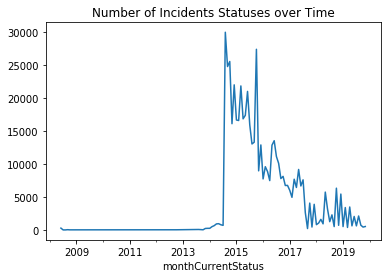

In [9]:
counts.plot()
plt.title("Number of Incidents Statuses over Time")

Now we immediatly see that a lot our incidents were torwards the end of 2014 and less were reported since then. 
This doesn't iteself answer our original question of why are almost all the statuses closed but it seems like most of the data was entered during this period when the data was marked as completed.

Now this is really odd... This is why. Remember how at the botumn of the previous <a href = https://github.com/harisx91/NYCHousingMaintenanceCodeProject/blob/master/notebooks/HousingCleaning.ipynb> notebook </a> I said that the Socrata API was not giving us a random sample? We can prove it here...

We have a count of how many incidents occured in 2016, 2017, and 2018 from the previous notebook Let's eyeglance (not using statistics) if the numbers match these. 

In [20]:
df_2016 = pd.read_csv('../data/inspection_2016.csv', parse_dates = ['inspectiondate'])
df_2017 = pd.read_csv('../data/inspection_2017.csv', parse_dates = ['inspectiondate'])
df_2018 = pd.read_csv('../data/inspection_2018.csv', parse_dates = ['inspectiondate'])
df_2014 = pd.read_csv('../data/inspection_2014.csv', parse_dates = ['inspectiondate'])

In [21]:
print('There are {:d} records in 2016 '.format(len(df_2016)))
print('There are {:d} records in 2017 '.format(len(df_2017)))
print('There are {:d} records in 2018 '.format(len(df_2018)))
print('There are {:d} records in 2014 '.format(len(df_2014)))

There are 513534 records in 2016 
There are 556883 records in 2017 
There are 642849 records in 2018 
There are 299592 records in 2014 


And by inspection on the graph... we can clearly see that this ratio does not hold. 2018 should have the most. Instead we have the increase in 2014. This is why in order to answer the question about what season incidents occur in we can't actually use this data. Lucky us, someone thought ahead and created all the data we need to evaluate this.

#### What season do most incidents occur in

From the city's perspective, this is very important. It can help with planning how much staff is needed. From a building owner's viewpoint, it is important to know when issues arise so that they can be prepared to fix the issues.

Let's create simple plots to try to visualize this

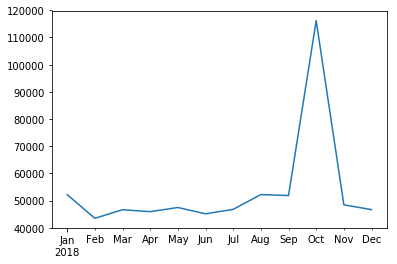

In [26]:
series = df_2018.inspectiondate.dt.to_period('M')
sortedcounts = series.value_counts().sort_index()
sortedcounts.plot()

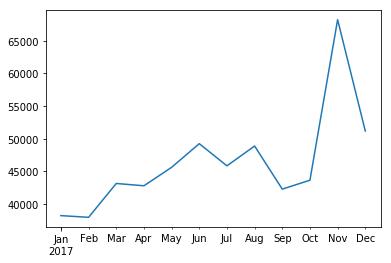

In [23]:
series = df_2017.inspectiondate.dt.to_period('M')
sortedcounts = series.value_counts().sort_index()
sortedcounts.plot()

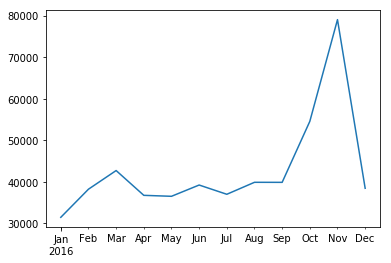

In [32]:
series = df_2016.inspectiondate.dt.to_period('M')
sortedcounts = series.value_counts().sort_index()
sortedcounts.plot()

It appears that most incidents are raised during the Fall, in either October and Novemeber

Let's take 2016 as an example. Although it appears that November has an overwhelming majority of incidents, we can do a statistical test to see if it is possible that this is just do to chance. 

Let's model this as a bernoulli random variable since there are 2 possibilities here. Either an inspection was in November or it wasn't. If all months had an equal number of incidents per month we would expect that each month would have 100/12 or 25/3 (8.3) percent of the incidents each month

In [33]:
n = sortedcounts.sum()
p = sortedcounts['2016-11']/n
q = 1-p
p

0.1538612827972442

We see that November had 15.4 percent of the votes... Almost twice as much as what we would expect the avg month to have.  
Now let's see the Probability that we would get this 15.4 percent if really there was no significant difference. We can state this in another way with a hypothesis test. 

Our null hypthosis is there is no significant difference
Our alternate hypothesis is that there is... That is, P(incident in November) >= 8.3%. 


An easy approach we can take is to make a confidence interval. This interval would give us a range of possible values that the true probability is.

We know from basic statistics we have the point estimator for target `p` with standord error `sqrt(pq/n`)`

In [38]:
import math
standordError = math.sqrt(p * q /n)
standordError

0.000503501602425762

In [39]:
er = 1.96 * standordError
lowerBound,upperBound = (p - er, p+er)
lowerBound,upperBound


(0.1528744196564897, 0.1548481459379987)

These numbers tell us that there is a 95% chance that the true value is between .1528, and .1548. Since 8.3 is not in the interval, we can say with 95 percent accuracy that there is a significant difference and more incidents are indeed opened in November. Moreover, from how far away this range is from 8.3, it is pretty clear that there is a wide gap.

So what do we gain from knowing this? Firstly, we reccomend that the city have lots of staff around for inspecting buildings during this period. We also recomend that building owners look to correct the issues in their buildings before fall so that they can be prepared for inspections.

#### Where do incidents take place

So now we contextualized our data a bit more... We know when the data was from and we know the what: that most of the rows show that the incidents were resolved. Let's now focus more on the what of how severe the incidents were and on the where. Where do most incidents take place? Also which areas are there the most severe incidents?

Text(0.5, 1.0, 'Incidents per boro')

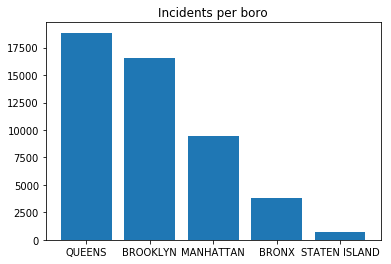

In [41]:
plt.bar(df['boro'].unique(), df['boro'].value_counts())
plt.title("Incidents per boro")

Queens has the most number of incidents with Manhattan, the Bronx, and Staten Island significantly less.
It's not just that there are more incidents though. The ratio of incidents between Queens and Brooklyn and the other boros is significantly more. We should investigate why this is? Is there something problematic about these buildings like are they older?

It's also important though to see how severe these incidents are...

In [42]:
df['class'].value_counts()

B    30359
C     9301
A     9064
I      653
Name: class, dtype: int64

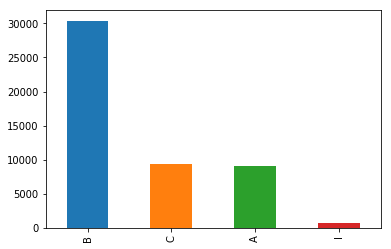

In [43]:
class_counts = df['class'].value_counts()
class_counts.plot.bar()

As we can see class B(which is medium severe) has the highest number. C is high severity and is about equal with A (low severity). I incidents aren't really violations but simply notifications. Now let's see if there are overly many severe incidents in any boros

In [44]:
df.groupby(['boro','class']).size()

boro           class
BRONX          A         3130
               B        10473
               C         2804
               I          112
BROOKLYN       A         3441
               B        11409
               C         3700
               I          310
MANHATTAN      A         1753
               B         5770
               C         1840
               I           87
QUEENS         A          642
               B         2242
               C          827
               I          138
STATEN ISLAND  A           98
               B          465
               C          130
               I            6
dtype: int64

Since Brooklyn has the highest number of incident, it makes sense that largest class incident happens there. 

It is easier to read if sorted

In [45]:
df.groupby(['boro','class']).size().sort_values(ascending=False)

boro           class
BROOKLYN       B        11409
BRONX          B        10473
MANHATTAN      B         5770
BROOKLYN       C         3700
               A         3441
BRONX          A         3130
               C         2804
QUEENS         B         2242
MANHATTAN      C         1840
               A         1753
QUEENS         C          827
               A          642
STATEN ISLAND  B          465
BROOKLYN       I          310
QUEENS         I          138
STATEN ISLAND  C          130
BRONX          I          112
STATEN ISLAND  A           98
MANHATTAN      I           87
STATEN ISLAND  I            6
dtype: int64

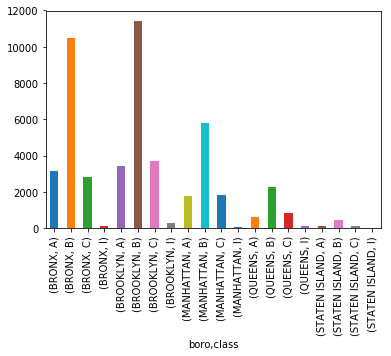

In [46]:
df.groupby(['boro','class']).size().plot.bar()

We don't see any boro which violates this ratio of having more class B incidents. Because of this we don't feel a need to propose any immediate action 

It might be usefull to see what this data looks like on a map. Let's create a map with dots representing how many incidents there were in certain zip codes. This will let us put more data into our graphs since the bar graph above already is bordering on the max number of bars

In [48]:
zipCounts = pd.read_csv(r'../data/zip_count.csv')

In [51]:
import plotly
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *

init_notebook_mode(connected=True)
token = ''
#px.set_mapbox_access_token(token) # You need a mapbox token to see the graph

fig = px.scatter_mapbox(zipCounts, lat="long", lon="lat", hover_name="city", hover_data=['zip','count'], # Yes, I flipped lat and long by accident
                        size = "count")
fig.update_layout(mapbox_style="light")
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0}, title = "Incidents per Zip")
plotly.offline.iplot(fig)

This graph shows the number of incidents in an area. The larger the circle, the more incidents To use this graph, simply click and drag to move around and use the mouse wheel to zoom in and out.


Hovering over any of the circles shows which zip code it is agregating over, the name of the city, and the number of incidents there. This graph is good because of how much data it is showing. We see that there are definetly areas where there are a lot of housing incidents.

This is really important when it comes to renting an apartment. This graph indicates areas where buildings tend to have lots of problems. A small disclaimer with this graph is that it is possible that some areas have more incidents just because there are more people. This is why we can't make any reccomendations from this graph. 

Now let's try to see if there is anything problematic about how long each boroough takes to respond to incidents. If there is a borough that takes too long,that would indicate problems with how incidents are being dealt with.  

In [22]:
inspection_date = df['inspectiondate']
current_status_date = df['currentstatusdate']

In [23]:
df['days_between'] = pd.to_timedelta(current_status_date - inspection_date, unit='d').dt.days
closed_issues = df[df['currentstatus'] == 'VIOLATION CLOSED']

In [24]:
daysOpenDf = closed_issues[['days_between', 'boro']]
daysOpenDf.head()

,days_between,boro
0,8066,QUEENS
1,7568,QUEENS
2,7568,QUEENS
3,7566,QUEENS
4,11005,BROOKLYN


In [25]:
daysOpenSeries = daysOpenDf.groupby('boro').median() #median to ignore outliers 

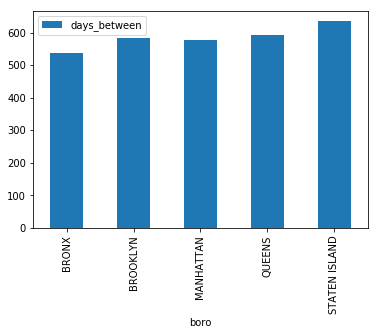

In [26]:
daysOpenSeries.plot.bar()

Staten Island seems to take the longest to repond to incidents. They also have the fewest number of incidents so this difference might not be significant. It's a pretty noteworthy observation that these numbers don't differ so much.
Although we found that certain boros have more incidents, the way they are dealt with is consistant and reasonable. This is good news! All that should be addressed is why Queens and Brooklyn have so many more incidents.  